<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>

## Basic Formatting operations in  Geo Dataframes

We will review some important formatting processes for geodataframes. As usual, let's do this: 

1. Create a repository named: formatgeodf.
2. Clone that repo to a local folder in your computer.
3. In that local folder in your computer, create a folder named **maps** and **data**.
4. Put the **geopackage** file that contains the three maps prepared last class into the map folder.
5. Commit and push: get the link for the **worldMaps.gpkg** from **formatgeodf** repo in GitHub cloud.

Let's read the file with the help of **geopandas**:

In [1]:
import geopandas as gpd
from  fiona import listlayers

#maps
worldMaps='https://github.com/CienciaDeDatosEspacial/code_and_data/raw/main/maps/worldMaps.gpkg'

#layers in maps
listlayers(worldMaps)

['countries', 'cities', 'rivers']

Retrieving each map (layer):

In [2]:
countries=gpd.read_file(worldMaps,layer='countries')
cities=gpd.read_file(worldMaps,layer='cities')
rivers=gpd.read_file(worldMaps,layer='rivers')

Making sure they have the same CRS:

In [3]:
countries.crs.to_epsg(),cities.crs.to_epsg(),rivers.crs.to_epsg()

(4326, 4326, 4326)

Subsetting the maps:

<Axes: >

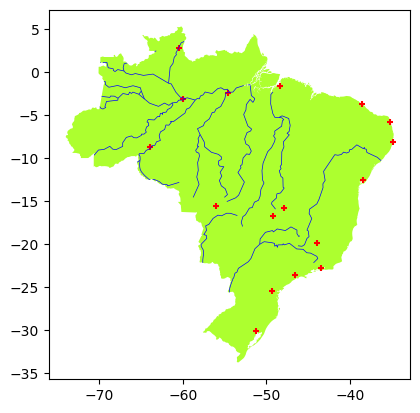

In [4]:
# just brazil
brazil=countries[countries.COUNTRY=='Brazil']

# clipping
brazil_cities= gpd.clip(gdf=cities,mask=brazil)
brazil_rivers = gpd.clip(gdf=rivers,mask=brazil)

# plotting
base = brazil.plot(facecolor="greenyellow")
brazil_rivers.plot(edgecolor='blue', linewidth=0.5,ax=base)
brazil_cities.plot(marker='+', color='red', markersize=15,ax=base)


## (Re) Projecting 

As mentioned in class, the CRS is a very important property of the maps. They affect three aspects:

* shape
* area
* distance
* direction

The most use CRS is 4326, but it is **not projected**:

In [5]:
# unit is in degrees:
brazil.crs.axis_info

[Axis(name=Geodetic latitude, abbrev=Lat, direction=north, unit_auth_code=EPSG, unit_code=9122, unit_name=degree),
 Axis(name=Geodetic longitude, abbrev=Lon, direction=east, unit_auth_code=EPSG, unit_code=9122, unit_name=degree)]

Some operations will **warn** you on this issue:

In [6]:
# perimeter
brazil.length

/var/folders/2n/bkfhfqq16r78g3hf7pdj56y40000gn/T/ipykernel_20320/789414184.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  brazil.length


29    248.380911
dtype: float64

In [7]:
# centroid
brazil.centroid

/var/folders/2n/bkfhfqq16r78g3hf7pdj56y40000gn/T/ipykernel_20320/515368123.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  brazil.centroid


29    POINT (-53.09009 -10.77302)
dtype: geometry

A projected CRS will have units in meters or feet (or similar):

In [8]:
brazil.to_crs(3587).crs.axis_info

[Axis(name=Easting, abbrev=X, direction=east, unit_auth_code=EPSG, unit_code=9001, unit_name=metre),
 Axis(name=Northing, abbrev=Y, direction=north, unit_auth_code=EPSG, unit_code=9001, unit_name=metre)]

In [9]:
brazil.to_crs(3587).centroid

29    POINT (11374671.933 -6303368.608)
dtype: geometry

<Axes: >

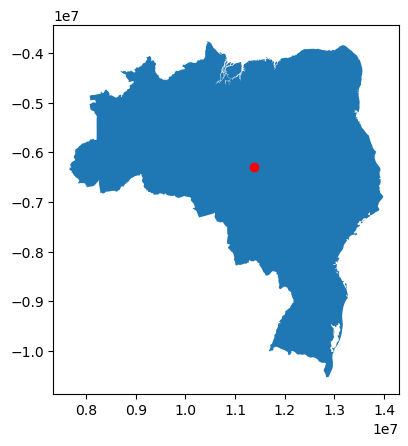

In [10]:
# plot this projected version

base3587=brazil.to_crs(3587).plot()
brazil.to_crs(3587).centroid.plot(color='red',ax=base3587)

The crs **3587** is a general option when there is a need to reproject a map. However, for a more accurate option it is better to look for the ones explicitly prepared for a map. You can request a crs per country [here](https://epsg.io/?q=brazil+kind%3APROJCRS):

In [11]:
# recommended for Brazil (meters)
brazil.to_crs(5641).crs.axis_info

[Axis(name=Easting, abbrev=X, direction=east, unit_auth_code=EPSG, unit_code=9001, unit_name=metre),
 Axis(name=Northing, abbrev=Y, direction=north, unit_auth_code=EPSG, unit_code=9001, unit_name=metre)]

In [12]:
brazil.to_crs(5641).length, brazil.to_crs(5641).centroid

(29    2.811312e+07
 dtype: float64,
 29    POINT (3884486.179 8756856.093)
 dtype: geometry)

<Axes: >

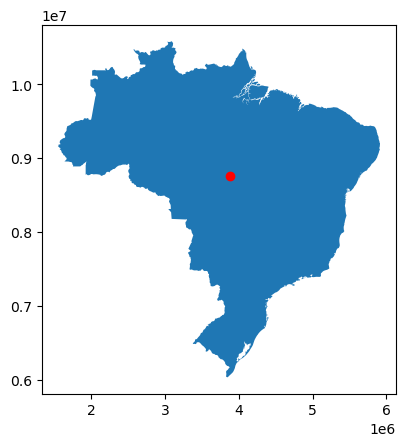

In [13]:
# replotting:

base5641=brazil.to_crs(5641).plot()
brazil.to_crs(5641).centroid.plot(color='red',ax=base5641)

Not using the right projection will give you a wrong numerical result when needing numerical accuracy; however, you might find situation where the visual output seems right (yet it is wrong):

/var/folders/2n/bkfhfqq16r78g3hf7pdj56y40000gn/T/ipykernel_20320/1876376191.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  brazil.centroid.plot(color='red',ax=ax2)


<Axes: >

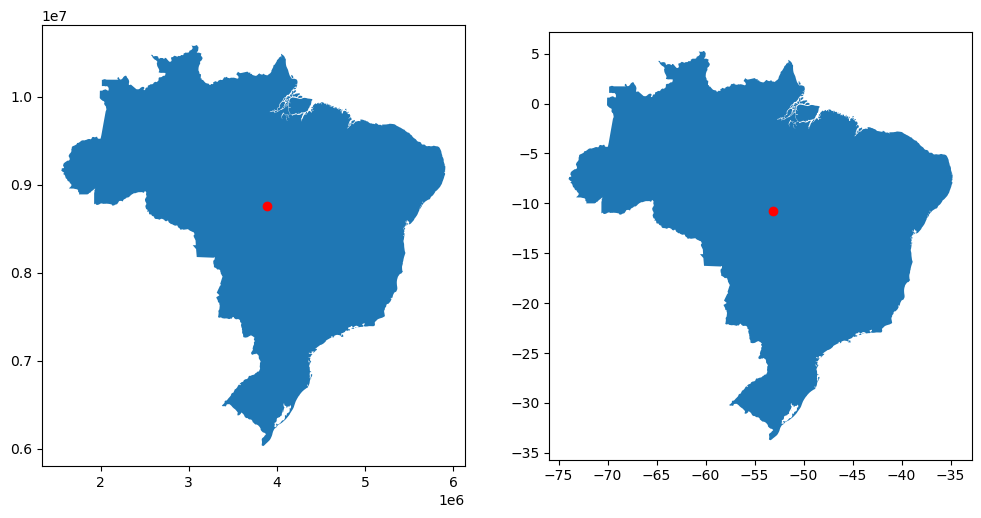

In [14]:
from matplotlib import pyplot

fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=False, sharey=False, figsize=(12,12))

brazil.to_crs(5641).plot(ax=ax1)
brazil.to_crs(5641).centroid.plot(color='red',ax=ax1)

brazil.plot(ax=ax2)
brazil.centroid.plot(color='red',ax=ax2)


Let's keep the projected version for all our maps:

In [15]:
brazil_5641=brazil.to_crs(5641)
cities_5641=cities.to_crs(brazil_5641.crs)
rivers_5641=rivers.to_crs(brazil_5641.crs)

In [16]:
cities_5641=cities_5641[cities_5641.COUNTRY=='Brazil']
rivers_5641=gpd.clip(gdf=rivers_5641,mask=brazil_5641)

In [17]:
# saving 
import os

brazil_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='border', driver="GPKG")
cities_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='cities', driver="GPKG")
rivers_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='rivers', driver="GPKG")

Reprojecting seems a simple process, but you might find some interesting cases. Download the shapefile of Brazil - Subnational Administrative Boundaries from [here](https://data.humdata.org/dataset/cod-ab-bra) and save it in the maps folder (you need to unzip the file).

In [18]:
brazil_estados=gpd.read_file(os.path.join("maps","bra_adm_ibge_2020_shp","bra_admbnda_adm1_ibge_2020.shp"))
brazil_municipios=gpd.read_file(os.path.join("maps","bra_adm_ibge_2020_shp","bra_admbnda_adm2_ibge_2020.shp"))

Notice this:

In [19]:
brazil_estados.crs, brazil_municipios.crs

(None, None)

It does not have crs information, however:

<Axes: >

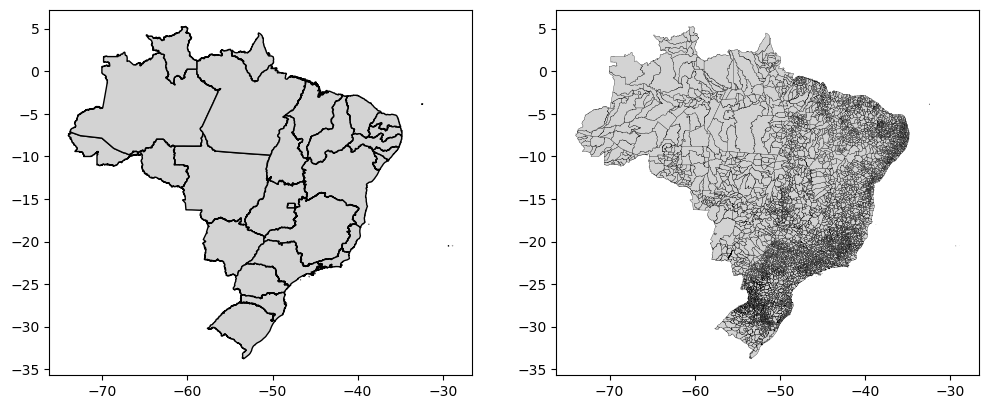

In [20]:
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=False, sharey=False, figsize=(12,12))

brazil_estados.plot(ax=ax1, facecolor='lightgrey', edgecolor='black')
brazil_municipios.plot(ax=ax2, facecolor='lightgrey', edgecolor='black',linewidth=0.2)


Since we are using the crs 3587, we may try:

In [21]:
brazil_estados=brazil_estados.to_crs(3587)
brazil_municipios=brazil_municipios.to_crs(3587)

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

Python says _"Please set a crs on the object first"_. Let's do it:

In [22]:
brazil_estados.crs = "EPSG:4326"
brazil_municipios.crs = "EPSG:4326"

Now, we can reproject:

In [23]:
brazil_estados=brazil_estados.to_crs(5641)
brazil_municipios=brazil_municipios.to_crs(5641)

Notice that now you have several polygons:

In [24]:
brazil_estados.shape,brazil_municipios.shape

((27, 6), (5572, 9))

In this cases, you can consider subsetting **by location**. In addition to _loc_ or _iloc_ (from pandas),  geopandas offers **cx**:

In [ ]:
centroBrazil=brazil_5641.centroid


fig, axs = pyplot.subplots(nrows=2,ncols=2,sharex=False, sharey=False,figsize=(8,8))

axs[0,0].set_title('Above_Centroid, LeftOf_Centroid',fontsize=5)
brazil_municipios.cx[:centroBrazil.x,centroBrazil.y:].plot(ax=axs[0,0]) 

axs[0,1].set_title('Above_Centroid, RightOf_Centroid',fontsize=5)
brazil_municipios.cx[centroBrazil.x:,centroBrazil.y:].plot(ax=axs[0,1]) 

axs[1,0].set_title('Below_Centroid, LeftOf_Centroid',fontsize=5)
brazil_municipios.cx[:centroBrazil.x,:centroBrazil.y].plot(ax=axs[1,0]) 

axs[1,1].set_title('Below_Centroid, RightOf_Centroid',fontsize=5)
brazil_municipios.cx[centroBrazil.x:,:centroBrazil.y].plot(ax=axs[1,1]) 

We update the file:

In [ ]:
brazil_estados.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='estados', driver="GPKG")
brazil_municipios.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='municipios', driver="GPKG")

## Creating Spatial data

You will get Lines and Polygons as maps for sure, but that may not be the case with points. Let me download a **CSV** file with information on the airports in Brazil from this [website](https://data.humdata.org/dataset/ourairports-bra), I will save it in my **data** folder:

In [ ]:
import pandas as pd 
infoairports=pd.read_csv(os.path.join("data","br-airports.csv"))

# some rows

infoairports.iloc[[0,1,2,3,-4,-3,-2,-1]]

This need some cleaning:

In [ ]:
# bye first row 
infoairports.drop(index=0,inplace=True)
infoairports.reset_index(drop=True, inplace=True)
infoairports.head()

In [ ]:
# keep the  columns needed

infoairports.columns.to_list()

In [ ]:
keep=['name','type','latitude_deg', 'longitude_deg','elevation_ft','region_name','municipality']
infoairports=infoairports.loc[:,keep]

In [ ]:
infoairports.info()

Some formatting:

In [ ]:
numericCols=['latitude_deg', 'longitude_deg','elevation_ft']
infoairports[numericCols]=infoairports.loc[:,numericCols].apply(lambda x:pd.to_numeric(x))

# now 
infoairports.info()

In [ ]:
# let's plot

base = brazil.plot(color='white', edgecolor='black')

infoairports.plot.scatter(x = 'longitude_deg', y = 'latitude_deg',ax=base)

Would that be ok? It is supposed to be right. 


Let me turn those coordinates into a map of points:

In [ ]:
airports=gpd.GeoDataFrame(data=infoairports.copy(),
                 geometry=gpd.points_from_xy(infoairports.longitude_deg,
                                             infoairports.latitude_deg), 
                 crs=brazil.crs.to_epsg())# the coordinates were in degrees

In [ ]:
# does it look better?

# let's plot

base = brazil.plot(color='white', edgecolor='black')
airports.plot(ax=base)

In [ ]:
#remember:
type(airports), type(infoairports)

Then this works:

In [ ]:
airports.to_crs(5641).plot()

In [ ]:
# this does not:
infoairports.to_crs(5641).plot()

Let's keep the projected version:

In [ ]:
airports_5641=airports.to_crs(5641)

Remember you have type of airports:

In [ ]:
airports_5641['type'].value_counts() # this will not work: airports.type.value_counts()

You can create several maps:

In [ ]:
# safe rename:
airports_5641.rename(columns={'type':'kind'},inplace=True)

# now subset
airport_small=airports_5641[airports_5641.kind=='small_airport']
airport_medium=airports_5641[airports_5641.kind=='medium_airport']
airport_large=airports_5641[airports_5641.kind=='large_airport']
airport_seaplane=airports_5641[airports_5641.kind=='seaplane_base']
airport_closed=airports_5641[airports_5641.kind=='closed']
heliport=airports_5641[airports_5641.kind=='heliport']

That may be useful:

In [ ]:
from folium import LayerControl


m = airport_small.explore(color="red",name="airport_small",show=False)
m = airport_medium.explore(m=m, color="blue",name="airport_medium",show=False)
m = airport_large.explore(m=m, color="black",name="airport_large",show=True)
m = airport_seaplane.explore(m=m, color="green",name="airport_seaplane",show=False)
m = airport_closed.explore(m=m, color="white",name="airport_closed",show=False)
m = heliport.explore(m=m, color="orange",name="heliport",show=False)

LayerControl(collapsed=False).add_to(m) #optional

m

In [ ]:
airport_small.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), 
                                   layer='airport_small', driver="GPKG")
airport_medium.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), 
                                    layer='airport_medium', driver="GPKG")
airport_large.to_file(os.path.join("maps","brazilMaps_5641.gpkg"),
                                   layer='airport_large', driver="GPKG")
airport_seaplane.to_file(os.path.join("maps","brazilMaps_5641.gpkg"),
                                      layer='airport_seaplane', driver="GPKG")
airport_closed.to_file(os.path.join("maps","brazilMaps_5641.gpkg"),
                                    layer='airport_closed', driver="GPKG")
heliport.to_file(os.path.join("maps","brazilMaps_5641.gpkg"),
                              layer='heliport', driver="GPKG")

## Validity of geometry

Geometries are created in a way that some issues may appear, especially in (multi) polygons.
Let's check if our recent maps on states and municipalities are valid:

In [ ]:
# non valid
brazil_estados[~brazil_estados.is_valid]

In [ ]:
# see the invalid:
brazil_estados[~brazil_estados.is_valid].plot()

It is difficul to see what is wrong. Let's get some information:

In [ ]:
# what is wrong?

from shapely.validation import explain_validity, make_valid

explain_validity(brazil_estados[~brazil_estados.is_valid].geometry)

We can solve the problem this way:

In [ ]:
# solving the issue:
brazil_estados['geometry'] = [make_valid(row)  if not row.is_valid else row for row in brazil_estados['geometry'] ]

In [ ]:
# any invalid?
brazil_estados[~brazil_estados.is_valid]

What about the other geodataframe?

In [ ]:
brazil_municipios[~brazil_municipios.is_valid]

In [ ]:
explain_validity(brazil_municipios[~brazil_municipios.is_valid].geometry)

In [ ]:
# varieties?
brazil_municipios['validity']=[x.split('[')[0] for x in brazil_municipios.geometry.apply(lambda x: explain_validity(x))]
brazil_municipios['validity'].value_counts()

In [ ]:
# solving the issue:
brazil_municipios.drop(columns=['validity'],inplace=True)
brazil_municipios['geometry'] = [make_valid(row)  if not row.is_valid else row for row in brazil_municipios['geometry'] ]
#any invalid?
brazil_municipios[~brazil_municipios.is_valid]

Let's save these:

In [ ]:
brazil_municipios.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='municipios', driver="GPKG")
brazil_estados.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='estados', driver="GPKG")

## Exercise

1. Do some research and find what could be a better projection for the maps you prepared last time.
2. Reproject the map.
3. Compute the centroid.
3. Find online a csv file with coordinates for the country you are using. Then, turn that csv into a map. Update the geopackage.
4. Take one of your maps with several polygons, and check and correct the polygons validity.
5. Make submaps, using the centroid as in this lesson.
6. Save every map in a geopackage.